# Week 13: Poly Square Mapping as a whole
Consider both boundary classification & distortion

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [1]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices, retrieve_triangles_with_edge
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_boundary_vertices_related_edges_2D, retrieve_boundary_edges_related_vertices_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.pyvista_util import preprocess, postprocess

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Visualization
import pyvista as pv
from pyvista import examples
import torch
import torch.optim as optim

from scipy.spatial import Delaunay

C:\Tool\Env\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<a name='1'></a>
## 1 - Test Example

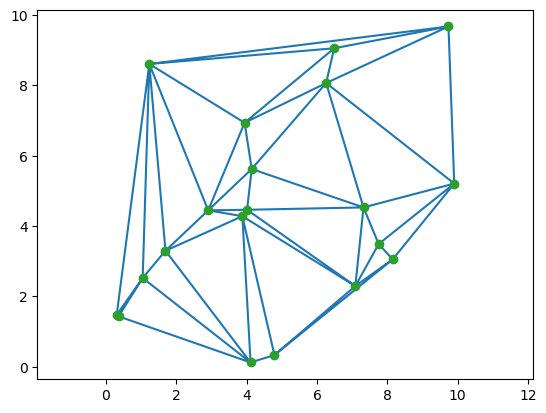

In [2]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=10
points[:, 1]*=10

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

faces=tri.simplices.copy()
vertices=points.copy()

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

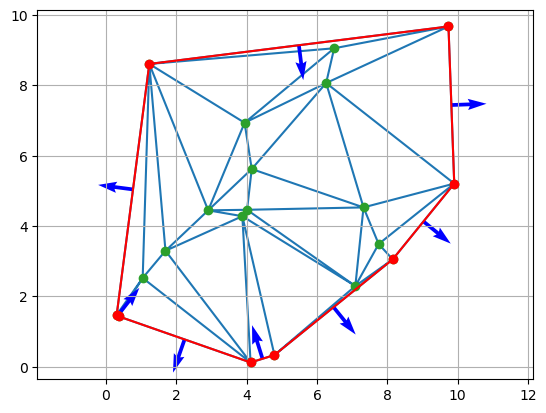

In [3]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


## New test

In [9]:
def retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges):
    adjacent = {v: set() for v in boundary_vertices}

    for edge in boundary_edges:
        v1, v2 = edge
        if v1 in adjacent:
            adjacent[v1].add(v2)
        if v2 in adjacent:
            adjacent[v2].add(v1)

    result = [list(adjacent[v]) for v in boundary_vertices]

    return result

def retrieve_adjacent_vertices_with_boundary_vertex(boundary_vertices, boundary_edges):
    adjacent = retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges)
    result = [np.append(np.where(boundary_vertices==v1), np.where(boundary_vertices==v2)) for v1, v2 in adjacent]

    return np.array(result)

In [10]:
BE_r_V = retrieve_boundary_edges(faces)
BV_r_V = retrieve_boundary_vertices(faces)
BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(BV_r_V, BE_r_V)

In [11]:
N = len(vertices[BV_r_V])

In [12]:
def activation(angle):
    if angle < (np.pi/2):
        return np.power(np.cos(angle), 2) / angle
    else:
        return np.power(np.sin(2*angle), 2)

In [13]:
def objective(BV_lambda):
    BV = BV_lambda[:2*N].reshape((N,2))
    lambda_ = BV_lambda[2*N:]
    
    E = 0
    for i, (v1, v2) in enumerate(BV_r_BV):
        edge1 = BV[v1] - BV[i]
        edge2 = BV[v2] - BV[i]
        
        edge1 = edge1 / np.linalg.norm(edge1)
        edge2= edge2 / np.linalg.norm(edge2)
        
        cos_theta = np.dot(edge1, edge2)
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        E_angle = activation(angle)
        E_align = np.sum(np.absolute(edge1)) + np.sum(np.absolute(edge2)) - 2
        
#         print(E_angle, E_align)
        
        E += E_angle + lambda_[i]*E_align
    return E

In [14]:
initial_guess = np.hstack([vertices[BV_r_V].flatten(), np.ones(len(vertices[BV_r_V]))])
# initial_guess = vertices[BV_r_V].flatten()

In [15]:
objective(initial_guess)

7.946685956479163

In [16]:
result = minimize(objective, initial_guess, method='SLSQP', options = {'maxiter': 10})

In [17]:
result

     fun: -19492.008906892544
     jac: array([ 5.14160156e-01,  3.75000000e-01,  6.66503906e-02,  1.08081055e+00,
       -8.05053711e+00, -6.77951660e+01,  6.91357422e+00,  6.71123047e+01,
       -7.49755859e-01, -3.19140625e+00,  9.85351562e-01,  4.99267578e-01,
       -9.19311523e+00,  5.23730469e+00,  9.51367188e+00, -3.31762695e+00,
        8.12988281e-01,  6.35009766e-01,  4.35058594e-01,  5.02685547e-01,
        4.16503906e-01,  6.92138672e-01,  4.17480469e-01,  6.89453125e-01])
 message: 'Iteration limit reached'
    nfev: 266
     nit: 10
    njev: 10
  status: 9
 success: False
       x: array([-1708.47580501,  2126.92723309,   770.80528108, -1293.54442707,
         -65.44194591,  -204.92157587,    31.84610439,  -215.6613595 ,
       -2361.02002487,  -196.39558152, -1317.98013062,  2445.07304212,
        2473.33402183,  -949.97818088,  2215.52300002, -1681.5900847 ,
       -5027.64087242, -2714.62365185, -2852.39151487, -4670.1867753 ,
       -4680.05276989, -1669.5143943 , -

In [19]:
BV=result.x[:2*N].reshape((N,2))

In [20]:
BV

array([[-1708.47580501,  2126.92723309],
       [  770.80528108, -1293.54442707],
       [  -65.44194591,  -204.92157587],
       [   31.84610439,  -215.6613595 ],
       [-2361.02002487,  -196.39558152],
       [-1317.98013062,  2445.07304212],
       [ 2473.33402183,  -949.97818088],
       [ 2215.52300002, -1681.5900847 ]])

In [21]:
solution = vertices.copy()
solution[BV_r_V] = BV

In [22]:
solution == vertices

array([[False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False]])

In [23]:
result.fun

-19492.008906892544

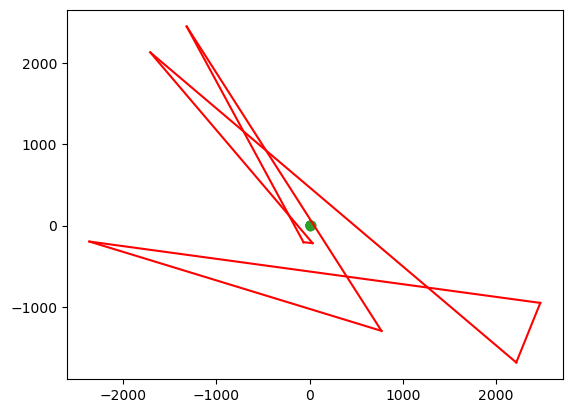

In [24]:
plt.triplot(vertices[:,0], vertices[:,1], tri.simplices)
plt.plot(vertices[:,0], vertices[:,1], 'o')
for edge in BE_r_V:
    plt.plot(solution[np.array(edge), 0], solution[np.array(edge), 1], 'r-')

In [22]:
# optimized_vertices_lambda = result.x
# optimized_vertices = optimized_vertices_lambda[:-1].reshape(-1, 2)
# optimized_lambda = optimized_vertices_lambda[-1]

In [23]:
vertices = vertices.reshape((N,2))

ValueError: cannot reshape array of size 40 into shape (8,2)

In [24]:
optimized_vertices

NameError: name 'optimized_vertices' is not defined

In [201]:
def objective(BV):
    BV = BV.reshape((N,2))
    
    E_angle = 0
    for idx_pairs in BV_r_BE:
        p1, p2 = BE_r_BV[idx_pairs[0]]
        p3, p4 =BE_r_BV[idx_pairs[1]]
        
        edge1 = BV[p2] - BV[p1] if (p1 == p3 or p1==p4) else BV[p1] - BV[p2]
        edge2 = BV[p4] - BV[p3] if (p3 == p1 or p3==p2) else BV[p4] - BV[p3]
        
        cos_theta = np.dot(edge1, edge2) / (np.linalg.norm(edge1) * np.linalg.norm(edge2))
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
#         print("hahaha")
        E_angle += activation(angle)
        
    return E_angle
    
def constraint(BV):
    
    BV = BV.reshape((N,2))
    
    E_align = 0
    for edge in BE_r_BV:
        A, B = BV[edge[0]], BV[edge[1]]
        E_align += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
        
    return E_align
        
def lagrangian_with_multiplier(vertices_lambda):
    lambda_ = vertices_lambda[-1]
    vertices = vertices_lambda[:-1]
#     .reshape(-1, 2)
    
    E_angle = objective(vertices)
    E_align = constraint(vertices)
    
#     print(E_angle, E_align, lambda_)
    return E_angle + lambda_ * E_align

In [163]:
def find_face_for_edge(edge, faces):
    for face in faces:
        for i in range(3):
            if set([face[i], face[(i + 1) % 3]]) == set(edge):
                return face
    return None

def retrieve_boundary_triangles_with_edges(boundary_edges, faces):
    return [find_face_for_edge(edge, faces) for edge in boundary_edges]

# 示例
faces = [
    [0, 1, 2],
    [2, 1, 3],
    [1, 0, 4],
    [4, 0, 5]
]
boundary_edges = retrieve_boundary_edges(faces)
test1 = boundary_edge_to_faces(boundary_edges, faces)
print(boundary_edges)
print(test1)


[(0, 2), (1, 3), (2, 3), (1, 4), (0, 5), (4, 5)]
[[0, 1, 2], [2, 1, 3], [2, 1, 3], [1, 0, 4], [4, 0, 5], [4, 0, 5]]


In [162]:
retrieve_all_edges(faces)

[(0, 1), (1, 2), (0, 4), (1, 4), (2, 3), (0, 2), (4, 5), (0, 5), (1, 3)]

In [ ]:
def objective(BV_lambda):
    BV = BV_lambda[:2*N].reshape((N,2))
    lambda_ = BV_lambda[2*N:]
    
#     print(BV, lambda_)
    
    E = 0
    
    for i, idx_pairs in enumerate(BV_r_BE):
        p1, p2 = BE_r_BV[idx_pairs[0]]
        p3, p4 =BE_r_BV[idx_pairs[1]]
        
        edge1 = BV[p2] - BV[p1] if (p1 == p3 or p1==p4) else BV[p1] - BV[p2]
        edge2 = BV[p4] - BV[p3] if (p3 == p1 or p3==p2) else BV[p4] - BV[p3]
        
        edge1 = edge1 / np.linalg.norm(edge1)
        edge2 = edge2 / np.linalg.norm(edge2)
        
        cos_theta = np.dot(edge1, edge2)
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
#         print(angle)
        E_angle = activation(angle)
        E_align = np.sum(np.absolute(edge1)) + np.sum(np.absolute(edge2)) - 2
        print(E_angle, E_align)
        lambda_i = lambda_[i] if lambda_[i] > 0 else 0
        E += E_angle + lambda_i * E_align
#         E += E_angle + E_align
        
    return E

In [40]:
class Chen_2023_scipy:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
#         self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
#             return np.power(np.cos(angle), 2) / (angle if angle > 0 else 0.1) 
            return np.power(np.cos(angle), 2) / angle
        else:
            return np.power(np.sin(2*angle), 2)
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E = 0
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            cos_theta = np.dot(edge1, edge2) / (np.linalg.norm(edge1) * np.linalg.norm(edge2))
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            E_angle = self.activation(angle)
            
            E += E_angle

        return E
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict=''):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            print("hahaha")
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [41]:
def retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges):
    adjacent = {v: set() for v in boundary_vertices}

    for edge in boundary_edges:
        v1, v2 = edge
        if v1 in adjacent:
            adjacent[v1].add(v2)
        if v2 in adjacent:
            adjacent[v2].add(v1)

    result = [list(adjacent[v]) for v in boundary_vertices]

    return result

def retrieve_adjacent_vertices_with_boundary_vertex(boundary_vertices, boundary_edges):
    adjacent = retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges)
    result = [np.append(np.where(boundary_vertices==v1), np.where(boundary_vertices==v2)) for v1, v2 in adjacent]

    return np.array(result)

In [42]:
test = Chen_2023_scipy(vertices, faces)

In [43]:
test.optimize_default()

In [44]:
test.res

      fun: 1.4022661015335098e-11
 hess_inv: array([[ 1.39269016,  0.53580551,  0.52614295, -0.8174415 , -0.03691629,
        -0.70816506, -0.05844036, -0.67115968, -0.30371394,  0.23033444,
        -0.0759365 ,  0.84235889, -0.3030631 ,  0.41308144, -0.13817686,
         0.40914003],
       [ 0.53580551,  1.459363  ,  1.05140061, -1.44540724,  0.46191214,
        -0.3528141 ,  0.4351144 , -0.29921987, -0.62995989, -0.28826302,
        -1.18010555,  1.63036087, -0.27868758,  0.48530313, -0.3888722 ,
         1.03804498],
       [ 0.52614295,  1.05140061,  3.24780368, -2.09732904,  1.26595111,
        -0.60538693,  1.24574534, -0.53402424, -0.9619783 , -1.67918419,
        -3.20132324,  2.5328821 , -0.79496893,  0.49640845, -0.32087876,
         2.09448402],
       [-0.8174415 , -1.44540724, -2.09732904,  4.43229342, -1.42825389,
         0.69051722, -1.39810102,  0.61190155,  1.12100212,  0.53659644,
         3.33178391, -3.86431154,  0.65794432, -0.69350333,  0.62761009,
        -1.40

In [45]:
test.mapping()

hahaha


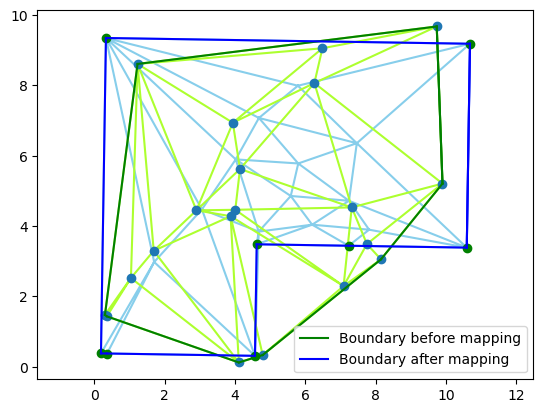

In [46]:
test.v_plt(show_vertices=True, show_origin=True, show_BV=True, show_inner_edges=True, save_dict='./problem.png')

In [10]:
tritess_v, tritess_f = preprocess('./mesh/tritess/tritess_input.ply')
test_tritess = Chen_2023_scipy(tritess_v, tritess_f)

In [ ]:
test_tritess.optimize(10)

In [ ]:
test_tritess.res

In [ ]:
test_cat.v_plt(show_origin=True)

In [16]:
class Chen_2023_torch:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BE = retrieve_boundary_vertices_related_edges_2D(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        return torch.where(angle < (np.pi/2), 
                           torch.cos(angle)**2 / torch.where(angle > 0, angle, torch.tensor(1e-8)),
                           torch.cos(angle)**2)

    def objective(self, BV):
        BV = BV.view(self.BV_num, 2)
        E_angle = torch.tensor(0.)

        for idx_pairs in self.BV_r_BE:
            p1, p2 = self.BE_r_BV[idx_pairs[0]]
            p3, p4 = self.BE_r_BV[idx_pairs[1]]

            edge1 = BV[p2] - BV[p1] if (p1 == p3 or p1 == p4) else BV[p1] - BV[p2]
            edge2 = BV[p4] - BV[p3] if (p3 == p1 or p3 == p2) else BV[p4] - BV[p3]

            cos_theta = torch.dot(edge1, edge2) / (torch.norm(edge1) * torch.norm(edge2))
            angle = torch.acos(torch.clamp(cos_theta, -1.0, 1.0))
            E_angle += self.activation(angle)

        return E_angle

    def optimize(self):
        x0 = torch.tensor(self.solution[self.BV_r_V], requires_grad=True)
        optimizer = optim.LBFGS([x0], lr=0.01, max_iter=self.max_iter) 

        def closure():
            optimizer.zero_grad()
            loss = self.objective(x0)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        print(loss)
        self.solution[self.BV_r_V] = x0.detach().numpy().reshape((len(self.BV_r_V), 2))
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
#     def optimize_default(self):
#         x0 = np.ravel(self.solution[self.BV_r_V])
#         self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
#         self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
#     def optimize(self, iter_num):
#         for i in range(iter_num):
#             self.optimize_one_round()
#             print("Round ", i, " done!")
    
#     def optimize_one_round(self):
#         x0 = np.ravel(self.solution[self.BV_r_V])
#         self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
#         self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict=''):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()